次は、金融市場でありがちな戦略に基づいて売買して、その成績に応じて戦略をまねさせる、バージョンを作りたい

### 前提条件

・対数正規分布に従うような企業の規模の変動

・企業規模に比例した「均衡」株価

・採用する戦略の種類は、同時に一種類のみ

・採用する戦略内で、パラメータ調整。パラメータは独自に振動しつつ、収益率の高いエージェントの真似をする傾向も加える

・預金×レバレッジが、買うための資金源

・いずれの戦略でも、ポートフォリオ配分割合目標を持つ


### 戦略（案）

・ファンダメンタルズに応じて売買する。長期的戦略。

・テクニカル分析に応じて売買する。短期的戦略。

・テクニカル分析に応じて売買する。長期的戦略。


In [14]:
using StatsPlots
using Random
using Statistics

In [15]:
mutable struct Agent
    strategy::String
    money::Float64
    sharesQuantity  #   株式保有部数リスト
    sharesRetainedLine  #   株式保有金額のリスト
    total_assets_log    #   資産総額の履歴
    params  #   パラメータのリスト  
    #   ファンダメンタルズ戦略をとる場合 [ポートフォリオに占める預金の割合の目標, 企業評価/時価総額　の、買いの閾値になる倍率, 企業価値/時価総額　の、売りの閾値になる倍率, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    #   インデックス戦略をとる場合      [ポートフォリオに占める預金の割合の目標, 1期のタイムスケール, α5, α4, α3, α2, α1, α0, β1, β2, γ, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    fundamentals    #   企業評価のリスト    ファンダメンタルズ戦略をとる場合しか使わないが、更新はインデックス戦略をとるときでも続ける
    portfolio_target#   ポートフォリオ配分目標。[預金,株式]
    performance::Float64    #   運用成績
end
mutable struct Firm
    stockPrice::Float64     #   株価
    stockQuantity::Float64  #   株式発行部数
    stockPriceLog   #   価格の記録
    stockQuantityLog    #   発行部数の記録
    marketCapitalization::Float64   #   時価総額
    hiddenCorporateValue::Float64   #   企業規模
    buy_offers  #   買い注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
    sell_offers #   売り注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
end
function update_hiddenCorporateValue(firms)
    σ_r, σ, μ = 0.02, 2.0, log(100.0)
    σ_p = sqrt(σ^2 + σ_r^2)
    for firm in firms
        f = firm.hiddenCorporateValue
        firm.hiddenCorporateValue = exp((log(f) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
function update_estimate_corporateValue(agents, firms)
    for agent in agents
        for (i, estimated_value) in enumerate(agent.fundamentals)
            agent.fundamentals[i] = (0.01*firms[i].hiddenCorporateValue + 0.99*estimated_value) * exp(0.01*randn())
        end
    end
end
function update_portfolio_target(agents)
    for agent in agents
        if agent.total_assets_log[end] <= 0
            agent.portfolio_target[1:2] = [0,0]
            continue
        end
        agent.portfolio_target[1] = agent.total_assets_log[end] * agent.params[1]
        agent.portfolio_target[2] = agent.total_assets_log[end] * (1 - agent.params[1])
    end
end
function cal_total_asset(agents)
    for agent in agents
        push!(agent.total_assets_log, sum(agent.sharesRetainedLine) + agent.money)
    end
end
function cal_sharesRetainedLine(agents, firms)
    for agent in agents
        for i = 1:size(agent.sharesQuantity)[1]
            agent.sharesRetainedLine[i] = firms[i].stockPrice*agent.sharesQuantity[i]
        end
    end
end
function fundamentals_trade_offer(agent, firms, j)
    buy, sell = [], []
    marketCap, estimated_value, α, β = 0.0, 0.0, 0.0, 0.0
    for (i, firm) in enumerate(firms)
        marketCap = firm.marketCapitalization
        α, β = agent.params[2], agent.params[3]
        estimated_value = agent.fundamentals[i]
        if α*estimated_value > marketCap
            push!(buy, (α - marketCap/estimated_value, i))  #   α - marketCap/estimated_value が大きいほど買いたい
        elseif β*estimated_value < marketCap && agent.sharesQuantity[i] > 0.0
            push!(sell, (marketCap/estimated_value - β, i)) #   marketCap/estimated_value - β が大きいほど売りたい
        end
    end
    sort!(buy)
    sort!(sell)
    going_to_sell_price, going_to_buy_price, k = 0.0, 0.0, 0
    #   戦略的な売り。調査に労力がかかることを考慮し、１期に１銘柄しか選べないという制限をかける
    if size(sell)[1] > 0
        x, k = pop!(sell)
        marketCap = firms[k].marketCapitalization
        stockQuantity = firms[k].stockQuantity
        quantity = agent.sharesQuantity[k]
        if quantity > 0.0
            price = (estimated_value + marketCap)/(2*stockQuantity)
            push!(firms[k].sell_offers, (price, quantity, j))
            going_to_sell_price += price * quantity
        end
    end
    #   ポートフォリオ配分を調整するための売り。際限なく売れる
    flug = true
    lst = []
    while agent.money + going_to_sell_price < agent.portfolio_target[1]
        if flug
            flug = false
            for (i, q) in enumerate(agent.sharesQuantity)
                if q > 0.0 && i != k
                    push!(lst, (i,q))
                end
            end
            shuffle(lst)
        end
        if size(lst)[1] == 0
            break
        end
        i, quantity = pop!(lst)
        price = firms[i].stockPrice
        push!(firms[i].sell_offers, (price, quantity, j))
        going_to_sell_price += price * quantity
    end
    #   戦略的な買い。調査に労力がかかることを考慮し、１期に１銘柄しか選べないという制限をかける
    if size(buy)[1] > 0
        _, i = pop!(buy)
        marketCap = firms[i].marketCapitalization
        stockQuantity = firms[i].stockQuantity
        price = (estimated_value + marketCap)/(2*stockQuantity)
        quantity = 1/agent.params[end]*agent.money/price
        push!(firms[i].buy_offers, (price, quantity, j))
        going_to_buy_price += price * quantity
    end
end
function chart_trade_offer(agent, firms, j)
    span = agent.params[2]
    if size(firms[1].stockPriceLog)[1] < span*6
        return nothing
    end
    α5, α4, α3, α2, α1 = agent.params[3:7]
    α0 = agent.params[8]
    β1, β2 = agent.params[9:10]                #   β1<β2 の条件を追加する
    sell, buy = [], []
    for (i, firm) in enumerate(firms)
        x1, x2, x3, x4, x5, x6 = firm.stockPriceLog[end-5:end]
        p = sum([α0 + α1*(x2-x1)/x1, α2*(x3-x2)/x2, α3*(x4-x3)/x3, α4*(x5-x4)/x4, α5*(x6-x5)/x5])
        if p < β1
            push!(sell, (-p,i))
        elseif p > β2
            push!(buy, (p,i))
        end
    end
    sort!(buy)
    sort!(sell)
    going_to_buy_price, going_to_sell_price = 0, 0
    γ = agent.params[11]    #   総資産に占める目標取引量の割合
    γ2 = (1 - γ/2)*agent.total_assets_log[end]
    while γ2 > going_to_buy_price && size(buy)[1] > 0
        p, i = pop!(buy)
        price = (1+p)*firms[i].stockPrice
        if price <= 0
            continue
        end
        quantity = 1/agent.params[end]*agent.money/price
        going_to_buy_price += price*quantity
        if going_to_buy_price > agent.money
            break
        end
        push!(firms[i].buy_offers, (price, quantity, j))
    end
    while agent.money + going_to_sell_price - going_to_buy_price < agent.portfolio_target[1] && size(sell)[1] > 0
        p, i = pop!(sell)
        price = (1-p)*firms[i].stockPrice
        if price <= 0
            continue
        end
        quantity = agent.sharesQuantity[i]
        going_to_buy_price += price*quantity
        push!(firms[i].sell_offers, (price, quantity, j))
    end
end
function trade_offer(agents, firms)
    for firm in firms
        firm.buy_offers, firm.sell_offers = [], []
    end
    for (j, agent) in enumerate(agents)
        if agent.strategy == "fundamentals"
            fundamentals_trade_offer(agent, firms, j)
        elseif agent.strategy == "chart"
            chart_trade_offer(agent, firms, j)
        end
    end
end
function cal_performance(agents)
    for agent in agents
        agent.performance = (agent.total_assets_log[end] - agent.total_assets_log[end-1])/agent.total_assets_log[end-1]
    end
end
function trade_matching(agents, firms)
    for (i, firm) in enumerate(firms)
        buy, sell = firm.buy_offers, firm.sell_offers
        sort!(buy)
        sort!(sell, rev=true)
        selling_p, selling_q, buying_p, buying_q = 0.0, 0.0, 0.0, 0.0
        trading_p = firm.stockPrice
        pb, qb, jb, ps, qs, js = 0.0, 0.0, -1, 0.0, 0.0, -1
        while buying_p >= selling_p
            if size(buy)[1] == 0 || size(sell)[1] == 0
                break
            end
            if buying_q == 0.0
                pb, qb, jb = pop!(buy)
                buying_q = qb
                buying_p = pb
            end
            if selling_q == 0.0
                ps, qs, js = pop!(sell)
                selling_q = qs
                selling_p = ps
            end
            if buying_p < selling_p
                break
            end
            trading_q = min(buying_q, selling_q)
            buying_q -= trading_q
            selling_q -= trading_q
            trading_p = (pb + ps)/2
            agents[jb].sharesQuantity[i] += trading_q
            agents[js].sharesQuantity[i] -= trading_q
            agents[jb].money -= trading_p*trading_q
            agents[js].money += trading_p*trading_q
        end
        firm.stockPrice = trading_p
        push!(firm.stockPriceLog, trading_p)
    end
end
function update_strategy(agents)
    if size(agents[1].total_assets_log)[1] < 10
        return nothing
    end
    performance10_lst = []
    for (j, agent) in enumerate(agents)
        performance10 = (agent.total_assets_log[end] - agent.total_assets_log[end-9])/agent.total_assets_log[end-9]
        push!(performance10_lst, (performance10, j))
    end
    sort!(performance10_lst)
    A = Int(floor(size(agents)[1]/10))
    best_agents = [pop!(performance10_lst)[2] for _ = 1:A]
    for agent in agents
        teacher = rand(best_agents)
        if rand() < 0.05
            new_strategy = deepcopy(agents[teacher].strategy)
            agent.strategy = new_strategy
            new_params = append!([agent.params[1]], agents[teacher].params[2:end])
            agent.params = new_params
        end
    end
end
function update_params(agents)
    for agent in agents
        agent.params[1] += 0.01*randn()
        agent.params[1] = abs(agent.params[1])
        if agent.params[1] > 1
            agent.params[1] = 1 - agent.params[1] % 1
        end
        agent.params[end] += rand(-1:1)
        if agent.params[end] <= 0
            agent.params[end] = 1
        end
        if agent.strategy == "fundamentals"
            agent.params[2] += 0.01*randn()
            agent.params[3] += 0.01*randn()
            if agent.params[2] < 0
                agent.params[2] = abs(agent.params[2] % 1)
            end
            if agent.params[3] < 0
                agent.params[3] = abs(agent.params[3] % 1)
            end
        elseif agent.strategy == "chart"
            if rand() < 0.01
                agent.params[2] += rand(-1:1) #   タイムスケール
                if agent.params[2] <= 0
                    agent.params[2] = 1
                end
            end
            agent.params[3:7] += 0.01*randn(5)
            agent.params[8] += 0.01*randn()
            agent.params[9:10] += 0.01*randn(2)
            if agent.params[9] > agent.params[10]
                agent.params[9], agent.params[10] = agent.params[10], agent.params[9]
            end
            agent.params[11] += 0.01*randn()
            if agent.params[11] < 0
                agent.params[11] = abs(agent.params[11] % 1)
            elseif agent.params[11] > 1
                agent.params[11] = 1 - agent.params[11] % 1
            end
        end
    end
end
function update_marketCapitalization(firms)
    for firm in firms
        firm.marketCapitalization = firm.stockPrice*firm.stockQuantity
    end
end
function run_one_term(agents, firms)
    update_hiddenCorporateValue(firms)
    update_estimate_corporateValue(agents, firms)
    trade_offer(agents, firms)
    trade_matching(agents, firms)
    cal_sharesRetainedLine(agents, firms)
    cal_total_asset(agents)
    cal_performance(agents)
    update_strategy(agents)
    update_params(agents)
    update_portfolio_target(agents)
    update_marketCapitalization(firms)
end

run_one_term (generic function with 1 method)

In [16]:
N, M = 10^2, 10 #   エージェント数, 株式会社数
init_money = 100.0*M/N
agents = [
    Agent(
        "chart",
        init_money,
        [1.0 for _ = 1:M],
        [1.0 for _ = 1:M],
        [2.0*init_money],
        [0.9, 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5],
        [init_money*N/M for _ = 1:M],
        [init_money, 0.1*init_money],
        0.0,
    ) for j = 1:Int(floor(N/2))
]
for _ = 1:(N - Int(floor(N/2)))
    push!(agents, 
        Agent(
            "fundamentals",
            init_money,
            [1.0 for _ = 1:M],
            [1.0 for _ = 1:M],
            [2.0*init_money],
            [0.9, 0.9, 1.1, 5],
            [init_money*N/M for _ = 1:M],
            [init_money, 0.1*init_money],
            0.0
        )
    )
end
firms = [
    Firm(
        1.0,
        100.0,
        [1.0],
        [100.0],
        100.0,
        100.0,
        [],
        [],
    ) for _ = 1:M
]

for t = 1:1000
    run_one_term(agents, firms)
end

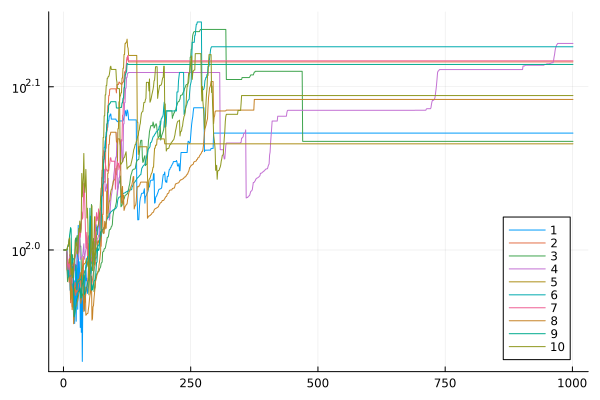

In [17]:
plot(firms[1].stockPriceLog.*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:M-1
    plot!(firms[i].stockPriceLog.*firms[i].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[M].stockPriceLog.*firms[M].stockQuantityLog, label=string(M), yscale=:log10)

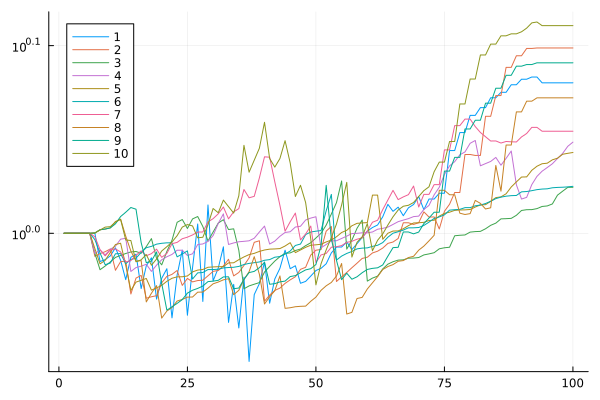

In [18]:
plot(firms[1].stockPriceLog[1:100], label="1", yscale=:log10)
for i = 2:M-1
    plot!(firms[i].stockPriceLog[1:100], label=string(i), yscale=:log10)
end
plot!(firms[M].stockPriceLog[1:100], label=string(M), yscale=:log10)

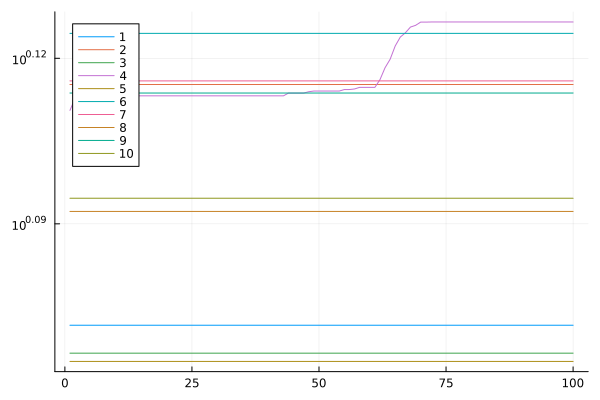

In [19]:
plot(firms[1].stockPriceLog[end-99:end], label="1", yscale=:log10)
for i = 2:M-1
    plot!(firms[i].stockPriceLog[end-99:end], label=string(i), yscale=:log10)
end
plot!(firms[M].stockPriceLog[end-99:end], label=string(M), yscale=:log10)

In [20]:
agents

100-element Vector{Agent}:
 Agent("fundamentals", 1.713224944307126e-10, [0.0, 0.0, 0.0, 7.939445945104702e-9, 0.0, 18.779642132787924, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0625906912472073e-8, 0.0, 25.015286467125737, 0.0, 0.0, 0.0, 0.0], [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 19.890880449718694, 19.74980590854154, 19.728182150483665, 19.810450306787892  …  25.015286477922967, 25.015286477922967, 25.015286477922967, 25.015286477922967, 25.015286477922967, 25.015286477922967, 25.015286477922967, 25.015286477922967, 25.015286477922967, 25.015286477922967], [0.7774665511415167, 1.1325225927472302, 1.1692542693956085, 15.0], [56.00208152236885, 74.98954209149267, 66.57646881102282, 286.3031704411149, 109.99608403216762, 156.180070067337, 129.60619124914555, 59.18722160146886, 91.66383302830612, 119.77149326183921], [19.44854850380779, 5.566737974115179], 0.0)
 Agent("fundamentals", 4.127161501038891, [0.0, 0.0, 0.0, 0.0, 0.0, 7.045512483930374, 0.0, 0.0, 0.0, 6.2180184445826825], [0.0, 0.

In [21]:
firms

10-element Vector{Firm}:
 Firm(1.1792921769476608, 100.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9659499839526025, 0.9682074613683219, 0.9726238600843635  …  1.1792921769476608, 1.1792921769476608, 1.1792921769476608, 1.1792921769476608, 1.1792921769476608, 1.1792921769476608, 1.1792921769476608, 1.1792921769476608, 1.1792921769476608, 1.1792921769476608], [100.0], 117.92921769476608, 49.55408062092579, Any[], Any[(1.172609628629462, 3.087690871970519, 79), (1.1567391000271514, 1.134060041808018, 91), (1.150572025260925, 2.000319977257409, 19), (1.1398156998336741, 7.094987629303364e-7, 84), (1.1398074669278915, 1.0, 59), (1.1263165801148356, 14.076208832559566, 80), (1.1248320590306298, 20.0662278625685, 18), (1.1171889210408867, 2.3598784072818346, 85), (1.1170007842953655, 1.4983149688672008, 3), (1.116556144188766, 14.402464551555124, 93), (1.1001030791368742, 18.31618256833483, 73), (1.0934721410821127, 0.6244075748756178, 88), (1.0888354336447368, 1.6643714149013866, 39), (1.08712

In [22]:
money_sum = 0
for agent in agents
    money_sum += agent.money
end
money_sum

1000.0000000000005

In [23]:
for firm in firms
    println(firm.hiddenCorporateValue)
end

49.55408062092579
73.13442120517878
65.33052337692023
381.25832677280505
97.57063203969406
211.06649252001418
114.17805835666367
52.13299443698588


104.57696914027117
86.76320443650604


In [24]:
for firm in firms
    println(firm.marketCapitalization)
end

117.92921769476608
130.39080199013392
116.56365198526521
133.83688214444973
116.1614715550805
133.20427668560743
130.58826381072035


123.66510543870824
129.92838886919677
124.34652518222178


In [25]:
for agent in agents
    println(agent.fundamentals)
end

[56.00208152236885, 74.98954209149267, 66.57646881102282, 286.3031704411149, 109.99608403216762, 156.180070067337, 129.60619124914555, 59.18722160146886, 91.66383302830612, 119.77149326183921]
[60.97176517506948, 94.27330041505263, 66.43414946950581, 310.90021108831814, 99.49632149093604, 186.51814107707722, 112.42671449400243, 57.69432865261658, 123.34830554080087, 102.69688527999864]
[62.47967307260837, 84.93585737714848, 72.15868379558029, 314.7614348417543, 112.20109259962804, 153.2402970923219, 137.44812617162148, 55.87079334088521, 110.20507971754073, 105.47093916430704]
[51.93154557680829, 87.61073351946402, 74.06094866028457, 285.01190910376965, 101.03194249371971, 175.3105129976686, 121.78231853506267, 56.19406449904002, 111.6522383274257, 102.98177560753626]
[54.373791582161815, 

89.2956944319038, 71.3661514919319, 313.9775611155924, 95.93020841095598, 159.16625961302748, 130.7004151662935, 59.767690898211235, 101.7557970139869, 104.52618087592292]
[59.026512466230784, 79.39887711856205, 80.29649123161892, 282.8205551466859, 102.95590456465874, 157.81386979649957, 124.21343141069346, 59.46197251210752, 93.16719653044066, 92.91721197823568]
[52.33715484251207, 78.98678225965405, 79.86989181143171, 266.3039162400007, 96.55611594910552, 166.75358339769832, 128.87111049540454, 56.737446312422485, 95.68629562365763, 100.34050952156758]
[56.033466411455336, 86.129128811432, 72.01901245307613, 303.58254642118663, 103.18570494837597, 178.92045070642592, 120.26824957330574, 63.08651626093131, 107.63779775745492, 98.47378413680961]
[58.21179929890947, 82.60279940104326, 68.0417438474932, 330.9406408338051, 107.55085389934573, 159.72661040877705, 112.52382028785378, 57.481597947428575, 116.54285685645083, 110.32656235107467]
[61.13866421026888, 74.78948274711125, 83.59503

, 285.80377871828904, 98.36565680327288, 161.71263256453065, 134.24099057178407, 56.496587903507375, 99.63051058626858, 104.82937746202583]
[52.8416447431028, 88.13127293459479, 64.71968493467858, 314.80738907521965, 96.78053629316621, 157.75127748205378, 119.62320509353742, 56.62881038420556, 108.86391609623752, 108.40566688604945]
[60.13879613505036, 77.25110893580658, 64.5658184045609, 315.00427615242705, 101.04111137922389, 164.47397289116333, 118.65759932714482, 62.01316174970388, 100.84695456665732, 111.25384961220477]
[52.203122186102526, 82.40719942043158, 77.3660492102721, 310.9525362936282, 108.0453131972862, 166.2866261696598, 117.67246924430641, 55.51578829784687, 106.18533030243357, 116.02294276645725]
[52.06963635983816, 73.76722779576468, 65.42678497112212, 349.3843561988954, 104.37232303690952, 174.50954962419797, 128.03188873083346, 61.44159290735695, 106.33474873072171, 106.15599601575198]
[55.36583040776934, 70.61038783363857, 70.33040869849945, 306.9680064046346, 11

, 105.61019111969631, 175.26891921583066, 120.43518180477373, 56.89992637992814, 90.78569072336056, 102.95720739759716]
[60.54656551625904, 81.84477973997181, 72.46541284285578, 309.77699146972077, 94.34819438397751, 171.13385318161042, 142.6306844125133, 61.7354966754105, 113.38969685310666, 102.86257112882987]
[55.70960070673784, 91.07030379480744, 78.01899941468801, 306.7001826525408, 95.12886320395017, 162.5847768630154, 116.48840086005086, 58.15366596960427, 99.21014566045235, 97.85352455515698]
[69.90035723782339, 71.58876453052298, 79.98748712989243, 333.91508442128224, 97.05903312499318, 170.3110867028847, 127.3576096414336, 56.893534395078966, 121.29802252716678, 104.69585827263292]
[64.3025006936398, 77.05330651307641, 70.10349299293904,

 310.7532977190037, 104.04366177969928, 155.57861657843958, 109.13024949568438, 54.269240583844486, 103.8949625499196, 99.49500462078332]
[54.10086338089316, 74.03990339603602, 72.83859943495773, 327.2225629286048, 106.57011067953991, 174.164452893691, 122.22590190342609, 61.11559536388913, 108.22731673195496, 107.2029334410559]
[52.68257193380871, 83.95545646271218, 69.09392161685278, 310.5140246094166, 87.83612638797231, 167.61760926897406, 124.32276275516091, 66.38948081004438, 97.51369361326505, 101.40689719012431]
[50.90968954031448, 77.2592433607679, 77.1788196004121, 286.9442096634022, 108.36539424787892, 157.38553927068182

, 107.90670751356225, 54.620444278917, 98.65403855486629, 106.74833719515256]
[52.55904543631676, 80.81036222535805, 69.92553854780357, 310.14107397522673, 103.98995032968412, 177.1170247782281, 124.41541454922852, 58.22715445590662, 105.99819344730302, 106.37233741085448]
[53.45724599856067, 75.30921861812865, 71.36814069739054, 326.464646579287, 108.71423094904458, 175.5854552445147, 128.60769970183728, 63.18435166869111, 106.70739457160307, 113.50682549222206]
[59.92430159929594, 83.58142190094975, 63.13720474733926, 313.31371547090475, 103.17699540028113, 148.19766529227314, 123.70892218670895, 55.75621551240397, 104.80275783575482, 98.07397176381886]
[62.82793710817027, 77.3808384896697, 69.06111648919588, 340.7142652291218, 122.06413998174071, 159.72392360676835, 122.58782487420854, 54.732641997681355, 101.69558896543285, 95.73230169547118]
[57.12140223591981, 94.26540722109225, 70.19956079565692, 300.30177538069785, 90.55674853787426, 165.6243638966693, 120.49448937480383, 64.63

, 136.5583689428416, 67.03155660468397, 101.4399846232413, 99.83786903418128]
[59.17470965387435, 78.1225390730378, 72.6311676251887, 322.5193702330666, 107.45914867965912, 158.95064171930608, 146.8948846243607, 61.226938375102144, 97.19701380293199, 116.17242388412176]
[52.68298505395293, 87.55509456470494, 66.63378447960004, 319.8491864126521, 103.17420079532094, 169.40727047925196, 123.29330195541617, 54.38862414605315, 98.79589072985371, 109.58628334685874]
[56.72808389297287, 79.85770056123864, 65.79506328518075, 311.1415029012046, 92.74530599093612, 168.18915281071187, 132.37301148218913, 59.71962247655731, 95.99054405246568, 101.66799376583141]
[59.98006663040308, 74.12173247257418, 66.59007283666163, 310.21985870909265, 101.13410876989465, 163.61154404303923, 125.5506452794952, 59.06347912945112, 100.11274553011302, 104.2189387356823]
[65.94838733348932, 76.45741943030592, 66.63649426762538, 297.02972111672995, 112.30188890996084, 171.04390412106628, 124.54412473254273, 55.3783

97.14369633917234, 69.05833852750334, 292.5962868163882, 112.84847825939704, 175.25493453073437, 117.82051835452233, 58.09453642108676, 103.0371100833809, 117.1303774557696]
[59.09269865936133, 69.44133090763964, 72.88617019855698, 294.65270817788615, 106.39240028672073, 158.3312295727883, 138.49818572001894, 58.612118079131584, 104.02764740890721, 103.05757722342399]
[57.73039278521929, 76.9706277107564, 70.10775835070342, 318.84057487713295, 90.87773600773325, 161.72476545321197, 136.9907704442315, 53.58189430434799, 101.64832265391112, 103.93222977980194]
[57.04968311966399, 94.51687475408555, 76.9253991175626, 321.6164160447485, 114.44303082072616, 181.21266152741148, 112.56826103555709, 57.4993804133859, 97.32302606185748, 106.6971067159176]
[56.982921658707895, 77.32370919473281, 81.90040328078055, 353.526496743406, 114.58520272238096, 156.1268174914766, 131.74262637596837, 59.64123517180776, 114.88719852100546, 97.78611215551281]
[61.234099974667025, 91.88770272637245, 71.742193

, 67.4948780396384, 313.50327802796056, 99.52795875190945, 167.0999258297495, 138.4598397597684, 53.30331084175662, 115.70258844271558, 102.06338061028352]
[55.91299099862189, 85.98018647605447, 76.69137841959441, 286.65249155926745, 107.52554499724752, 185.89084292549074, 134.54672057564946, 53.57815850251987, 105.1374975553774, 105.68553923470022]
[60.95788224058346, 87.80526052031055, 75.10053277899024, 314.53819226360156, 97.77575391486498, 156.85025921188702, 117.20431093941004, 60.25111527942865, 101.23780674845553, 112.1676590874791]
[60.83063733893432, 88.56287754354834, 70.67298325213605, 300.01601471587, 110.46770611744421, 169.6566112011978, 135.7670368592112, 59.31119634728578, 95.77625883070971, 100.75380082137748]
[50.03721885266901, 91.24420668773628, 67.58327052968072, 309.1379152774294, 123.11817169459007, 164.94795149962948, 111.90789013458156, 58.294181010203936, 95.17679687495755, 98.69903265779945]
[60.261663011590485, 94.51825127979188, 68.67391736580964,

 285.95311423566915, 110.37673466582442, 155.56926364157357, 123.23932677042751, 56.85042308715096, 105.43523109721963, 110.03227569081223]
[52.76452654724777, 75.51056547759428, 73.4165945339527, 311.39763668303334, 109.59400190019224, 164.76198784671703, 122.89624413369854, 52.496172164728875, 102.00754694735649, 92.99755963144361]
[65.284308704992, 89.60484231345593, 70.56645043058136, 335.3554924767239, 109.11840294475444, 138.84760819126012, 125.28967013415601, 54.276904589451696, 116.71732586593427, 111.01451528906794]
[63.95429574329187, 75.83645780451374, 94.91165835144415, 293.98959130096614, 103.34066273772217, 146.950321829118, 113.02635998821741, 59.60619788388961, 96.44076391926336, 113.2388737698062]
[53.78532873014956, 85.11197878937789, 64.27444429613745, 317.55048131974496, 92.53071021127612, 170.64531936643658, 135.6010562552105, 62.397798639195244, 99.4277357464666, 103.29409541100198]
[57.337146262716715, 73.72345629835822, 68.2601403363394, 324.83593388744913, 107.

, 159.05117538992866, 108.16500224883303, 55.79204897701711, 104.47762918325718, 105.76951582624]
[50.12412524883547, 90.32097668444575, 66.08621456372822, 334.4398414354716, 96.89554701319373, 174.98384995185037, 109.52053730792105, 55.008226289569116, 103.16010869403722, 104.76757367441387]
[59.73075013366958, 74.4417652790559, 72.20959077296803, 290.7172171887168, 107.20043262847301, 171.9602490837371, 125.25889515271083, 54.81718184607205, 97.05985486024248, 112.27782297757747]
[56.64708485060608, 94.08945707432814, 77.96481938398945, 285.5958459307415, 91.39053291847893, 179.82813295185977, 129.93376070654244, 61.743401482570306, 101.74835249111754, 109.27128993329127]
[52.973526649650886, 98.75350320353536, 70.75701181451639, 287.6393313670371, 109.44048059987657, 159.1301602644303, 118.31629833882606, 55.13377725200427, 108.52050469279237

, 109.56772732114666]
[66.47849997198931, 79.95319263260156, 96.06307156242612, 302.4533554672612, 97.63024243823766, 161.4573847457839, 147.6792520716233, 57.36757677178287, 93.27747548230958, 98.71261769678652]
[54.418033190390034, 79.16220945230071, 78.55545857374368, 347.68200457856216, 95.01165828931747, 165.18822555315145, 120.39724101332106, 51.922313648377205, 115.47360134994153, 102.09139813260877]
[60.6572974569647, 82.8984698486586, 71.0109981297127, 309.27967450791317, 103.16901623496582, 162.32971885966646, 119.99069270215068, 57.68621597536321, 115.03965748911452, 107.15457383351541]
[52.25420708314454, 89.19723846400157, 59.101470725557874, 308.20842118169384, 101.29600775205263, 159.78172841384634, 131.90648569171378, 61.57123973889016, 100.81023875406215, 117.5700885564883]
[61.56824376127695, 80.2978914418299, 81.71459556130279, 312.26586080091414, 96.45558761263246, 147.26260825023147, 125.48462753359227, 56.74353137362561, 100.75256788967174, 109.54792665830323]


[62.52201814146773, 88.909271215136, 75.55996976937887, 295.81088655624063, 105.23093126893143, 156.67048737746524, 116.64949474103707, 55.1675444589815, 98.63376080995495, 106.19806627379819]
[64.65610998991961, 83.98905390088136, 73.91662679073615, 321.05310988817837, 94.46312615562992, 182.28500731843923, 117.41145907088357, 58.95080313029616, 106.96918867612594, 103.96193358286372]
[51.592646035922485, 78.97180052282474, 71.82812968644518, 279.00610889304704, 112.80746499115578, 175.79152703470734, 128.5026206543672, 54.4369396850235, 100.37965584734998, 116.59270803112634]
[57.04347728320969, 81.66477388295583, 81.08848101077581, 293.01891762072216, 110.35824293803532, 155.94774731913415, 119.94128605540568, 58.85736407275792, 115.70094901902871, 107.33409832820102]
[51.442375386020636, 85.89812916821639, 70.87866752027497, 283.5953365500285, 103.25447899678653, 160.1350467340917, 120.89062337618101, 65.14537072416302, 113.20094479334388, 103.29241606897567]
[56.43564374816244, 76

]
[56.87974028711744, 81.58048872648921, 68.3742894333095, 331.7403682753253, 97.90625041381237, 170.4707190976011, 119.41577282857192, 55.134139842058524, 97.75714631400153, 107.33069325816602]
[62.58553954276568, 91.92956082231652, 76.16629965871842, 300.28251388329943, 90.87265263327863, 171.59712151026355, 140.90019380918105, 55.35728207799022, 119.70321009746114, 108.05931369079373]
[59.49689214927428, 80.85629126887494, 73.14660337194307, 281.2210190825033, 108.48320726358227, 175.43457393131516, 124.2249908892676, 63.15154378154669, 121.24499209025029, 100.76521052165644]
[59.552198413177535, 86.06379612556508, 63.57795530297549, 310.76992654435986, 106.81554753318073, 176.59677684796472, 134.0118678353474, 60.76340489869639, 107.91986283247613, 87.72751634138245]
[55.806185415929875, 88.4612442062048, 75.06805608326614, 300.11461167999744, 107.0379739756527, 166.42515072518702, 123.45192689896524, 59.199392867263825, 87.15752943331161, 93.25454945624158]
[59.56650442962564, 76.

93.40029999918191, 106.50470691355885]
[58.662611930599915, 84.96621708679153, 79.26736766700809, 325.96358959600195, 98.19911094034381, 170.20672621754983, 114.24405747028788, 56.81328024789967, 108.38046508171581, 93.38276508635641]
[60.709553427668354, 77.2518452085825, 80.01642189007474, 270.556847818115, 93.6876771287012, 150.39175496790256, 134.89433394527435, 55.27425553009631, 96.67507392261925, 112.46468243388271]
[61.13469941911246, 75.37419915481495, 74.5738481903891, 306.7585079049331, 106.31877164310637, 172.8909422325404, 104.32190319892625, 55.6023029932472, 117.07783822125265, 98.20033906420734]
[61.21386714230634, 73.57943958915658, 78.38359839865473, 307.41275887655235, 113.52347976428048, 174.62657582054615, 127.24129148676829, 53.80160882902925, 98.78733937155125,

 104.90879979465232]


In [26]:
for agent in agents
    println(agent.params)
end

[0.7774665511415167, 1.1325225927472302, 1.1692542693956085, 15.0]
[0.7799843385985626, 1.1732230466989657, 1.1779461412632182, 9.0]
[0.9897525514629529, 1.316542695877466, 1.0545852311744892, 11.0]
[0.5073246306844608, 1.2037350985594317, 1.0347982251535937, 23.0]
[0.8700376254890224, 1.3630494594310623, 1.0762090567048928, 12.0]
[0.575236239409722, 1.2377553643948374, 1.2157220092127017, 17.0]
[0.8897002471147812, 1.3723463952027692, 1.2013293578351507, 8.0]
[0.5420771725782311, 1.3256276672393303, 1.0057409059019964, 17.0]
[0.23675349631658496, 1.14095491672234, 1.0812524957369267, 7.0]
[0.9830220043882782, 1.3266172299112173, 1.074395578742131, 16.0]
[0.80288698395903, 1.416559305015516, 0.9707002436737214, 19.0]
[0.6658143560688873, 1.3335026436763144, 1.1008642507079072, 11.0]
[0.7111524857156808, 1.2470473154608137, 1.1368788007240587, 14.0]
[0.6494474620598001, 1.3458328276617404, 1.1284719558091798

, 7.0]
[0.3700677626579659, 1.1809379629770171, 1.0226964146458706, 8.0]
[0.9990000565679927, 1.3722803066777802, 1.1654322823345342, 12.0]
[0.72745622458281, 1.0923761605843072, 1.1785684790463489, 10.0]
[0.8865036577550707, 1.3488195790446607, 1.039737958273735, 8.0]


[0.5000202342936962, 1.3346027720569114, 1.1755187437225192, 8.0]
[0.7700317289861252, 1.2460816979873328, 1.0686187833541108, 21.0]
[0.6715989931327884, 1.3000951008902015, 1.09466709826956, 2.0]
[0.8228988729828653, 1.2547778523095305, 1.1112075067366147, 7.0]
[0.4208985678610761, 1.0670975571767607, 1.1671258149725499, 20.0]
[0.4538133961378818, 1.2376711779297331, 0.9441178359274569, 6.0]
[0.9720027060203125, 1.0724980611735049, 1.1542694364895911, 5.0]
[0.8047910282297258, 1.2611931484872296, 1.071195553987976, 8.0]


[0.4892178918228909, 1.091792327944419, 1.203211151796784, 9.0]
[0.9685096676078356, 1.437414750879478, 1.0578940102435028, 7.0]
[0.44282636705965145, 1.34067062311856, 1.1529600485639793, 14.0]
[0.7663791095769796, 1.2457172110016066, 1.2099949289371388, 9.0]
[0.7365279427704304, 1.1443436628871404, 1.249498399045035, 18.0]
[0.8912494548013282, 1.2961413648234947, 1.057081134740615, 9.0]
[0.9547481718287526, 1.2791823024686886, 1.0252412565640683, 14.0]
[0.6238384081650313, 1.316735689233607, 1.1219602056327458, 13.0]
[0.9283407336415653, 1.2224428040417747, 0.9841827645881202, 13.0]
[0.9684390710122394, 1.1550654255991109, 1.1111065266343925, 10.0]
[0.9007267111875141, 1.4545273265808232, 1.0296631390170763, 7.0]
[0.9409243665895817, 1.3826373454858332, 1.1732051445382172, 8.0]
[0.8883079974381302, 1.4168061765177715, 1.1566020803287866, 2.0]
[0.7443590840092902, 1.3524568125735283, 1.154126524103868, 11.0]
[0.7861158504045623, 1.145170324937646, 1.1453526247728818, 6.0]
[0.855913052

[0.9250667765767817, 1.3500595407358946, 1.051366832330596, 12.0]
[0.7211744257274195, 1.0778982902121708, 1.1685463137699663, 17.0]
[0.7546165920371968, 1.3235706588222782, 1.0973265685496632, 12.0]
[0.7477184504455676, 1.1297591556417277, 1.2646468871134613, 13.0]
[0.7802869572330979, 1.2367925245841374, 1.1476069105481683, 12.0]
[0.7848219871215756, 1.230499895345354, 1.1866658913960682, 2.0]
[0.9250886600460206, 1.2812227897256045, 1.3814110376734905, 7.0]
[0.9776850469630721, 1.1000831287592863, 1.1455730104738873, 10.0]
[0.8235947002920826, 1.3155959799701835, 1.117451537703467, 14.0]
[0.7801727580246952, 1.121682363599045, 1.2286668630221065, 16.0]
[0.8845998010696849, 1.1759491996429832, 1.1949918037152265, 13.0]
[0.9829649589880385, 1.2451335729004418, 1.2149252324197917, 4.0]
[0.9350105990215428, 1.2556668314660964, 1.0739822451627161, 20.0]
[0.5057357209520288, 1.3921354615897041, 1.0889338457669089, 5.0]
[0.9991111561179764, 1.2357019328372127, 0.942476833780067, 18.0]
[0.3

[0.5531921092948021, 1.2517884226138096, 1.2148118613738268, 13.0]
[0.9774975486808418, 1.3911846392188845, 1.1020470955289499, 13.0]
[0.6262024928463382, 1.3233934104810758, 1.227058637064956, 4.0]
[0.8114915975222109, 1.2868919245806876, 1.1007171748772402, 9.0]
[0.7918066345910427, 1.2879659649350519, 1.1393978548514345, 11.0]
[0.9847951418184211, 1.274108556006552, 1.0028901506978132, 12.0]
[0.8999507443921292, 1.116563299834007, 1.164521762122192, 15.0]
[0.7994173307799899, 1.3558063616298872, 1.1054383360518123, 8.0]
[0.7873243300765072, 1.0857840076009226, 1.1818204893592203, 12.0]
[0.12167578263067196, 1.2787755875076947, 1.0990143715558436, 7.0]
[0.8180942646463158, 1.0673216604102385, 1.1480465287925052, 9.0]
[0.8915833354878481, 1.3746613376544092, 1.1569485012439347, 6.0]
[0.8781447073854208, 1.3393421741936784, 1.1535516160644415, 14.0]
[0.9237458351966557, 1.1703298986981987, 1.044620844647984, 20.0]
[0.9921581074888525, 1.2683946482551054, 1.0296603457457336, 4.0]
[0.427

 1.152030764366688, 12.0]
[0.9244670023008906, 1.2009359072033472, 1.1361721332329167, 9.0]
[0.7372431848825259, 1.4368541402941, 1.0697219439441665, 2.0]
[0.8419781748857368, 1.3265879438520527, 1.160700910918839, 6.0]
[0.35664776342625826, 1.3586601999311267, 1.0792307613644976, 11.0]
[0.8686928513959453, 1.1553148900188284, 1.2461391321198794, 23.0]
[0.7758395784917043, 1.3632054338161048, 0.9048647338532289, 10.0]
[0.9386075286594823, 1.3231218593137153, 1.1609898117276563, 14.0]
[0.9794789758936547, 1.3473979390638804, 1.0429431007808005, 12.0]
[0.9320574720097332, 1.3256194259714742, 1.056757402348077, 10.0]
[0.8671966060617241, 1.2602042631056087, 0.9799830171626785, 13.0]
[0.6442066875664216

, 1.3479879004138817, 1.0752315552243907, 10.0]
[0.8457341349138563, 1.3368852136774665, 1.1890685312185825, 8.0]
[0.8075064799260678, 1.314673232067828, 1.1314380563762703, 8.0]
[0.8206043933529328, 1.1269904556064674, 1.259351833135167, 12.0]
[0.4136272791527442, 1.0999621538292501, 1.1636147104049783, 6.0]
[0.7110076283093005, 1.1181453472739142, 1.2324190123296432, 13.0]


In [27]:
for agent in agents
    println(agent.sharesQuantity)
end

[0.0, 0.0, 0.0,

 7.939445945104702e-9, 0.0, 18.779642132787924, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 7.045512483930374, 0.0, 0.0, 0.0, 6.2180184445826825]
[1.4983149688672008, 0.7981731267750021, 0.0, 0.0, 0.0, 0.0, 1.8354679102118863, 0.0, 1.6003395492445258, 0.0]
[0.0, 0.0, 0.0, 0.0005670636381506358, 0.002325473859914101, 0.0013411148424984762, 0.0, 1.5210036644310199, 18.176771078300856, 0.0]
[0.0, 0.0, 0.0, 1.0145662884210787, 0.047700297886759335, 0.0, 15.723345779778631, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.7075750949518116, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 19.514613479703343, 0.0, 0.0, 0.0, 

0.0, 0.0, 0.0015039325301011944, 0.0, 0.0]
[0.0, 0.0, 16.52801264582513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.40969408377024047, 0.0, 2.132548951515801e-34, 1.3204485419992174, 17.75700249313665]
[0.0, 0.0, 0.0, 0.6944838631206702, 0.0, 0.0, 0.0, 18.899735665073916, 0.0, 0.0]
[3.319784587531932, 1.9877770957365803, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.07591677267587048, 0.4333368750623628, 0.0, 0.0, 0.0, 5.488470566846905, 0.0, 11.507021557893307]
[0.0, 0.0, 0.14122533341838908, 18.85354800252582, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.633341567116317, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.947674302703636, 0.0]
[0.0, 0.0, 0.0, 6.459138175902763e-15, 0.0, 19.719829767422432, 0.0, 0.0, 0.0, 0.0]
[20.0662278625685, 0.0, 

0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[2.000319977257409, 0.4098607910622462, 0.0, 0.0, 0.2982682278320349, 0.0, 2.886961793552694, 0.0, 4.4380780458243325e-16, 0.0]
[0.0, 0.0, 0.1411667484850002, 0.0, 1.5977372432784946, 0.0, 0.0, 0.0, 0.0, 1.991029943929115]
[0.0, 0.0, 0.0, 0.7935843551726823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.3662847504270764, 0.0, 7.627134346464024e-14, 0.0, 0.0, 

0.0, 0.0]
[0.0, 0.2031084692394089, 0.0, 0.0, 0.0, 0.0, 5.880430831097257, 1.4100120195544, 0.17066431406181612, 0.0]
[15.588364071830828, 0.0, 0.0, 0.0, 0.0, 1.7491789147228418, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.4302364143207356, 0.0, 0.0, 10.921093526107647, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 3.9211006343717876, 0.3669628928551326, 12.886592904199862, 5.681462984200314e-7, 0.0, 0.00020210898808436977]
[0.007648995617147355, 0.43199572365288974, 1.670598675734366, 0.0, 10.435404073837102, 0.0, 2.5758612895189996, 3.2088678764369356, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0,

 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 2.494235373234997, 0.0, 0.0, 0.0, 0.0, 14.667622412531543, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.670893028378254, 0.0, 0.6020084121766068, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 18.579146612129826, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8435399111302528, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.006844445117195078, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 20.786830819776412, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.6643714149013866, 19.71339538269912, 0.0007655174032275199, 0.0, 0.0, 0.0, 0.0, 0.006286040137571269, 0.0, 0.019241586572963328]
[0.0, 0.0, 0.0, 0.0, 0.2178201088413785, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.014228726902674894, 0.0, 0.08042111839161052, 0.0, 0.5025578674331441, 0.0, 11.619989084755584, 0.0, 0.0]
[0.0, 0.0, 0.0, 6.2517170749409905, 0.0, 0.0, 0.0, 0.0, 

0.0, 0.0]
[0.0, 0.0, 0.00852364983376296, 0.0, 20.35046960121718, 0.0, 0.0, 7.320790390984519e-5, 0.0, 0.0]
[0.0, 1.0936195231916412, 0.0, 0.0, 0.0, 0.0, 1.3189303004703283, 0.0, 1.3696968571995263, 0.0]
[0.0, 2.3916400919933576, 5.831564479023239, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.9111537176775297, 0.0, 0.0, 0.0, 19.91554019432582, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0533336119631351, 0.0, 19.261764905285766, 0.0]
[0.0, 0.0, 0.0, 1.8208618970402999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.15453706812816684, 0.3831907078086379, 0.0, 0.04737130974113827, 0.0, 1.1094483128254825e-36, 0.0, 18.91527412382876]
[0.0, 0.10496940357036051, 0.04925395534141377, 0.4215338808115236, 0.0, 0.0, 4.376647860557314, 0.7958609284290269, 3.0461616449733735, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.9890743370354773, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

11.979419660080952]
[0.0, 0.0, 0.0, 17.165465324717946, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.004612178405707807, 0.0, 0.0, 0.0, 0.4396043948961341, 18.744697699053713, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 17.739765792533248, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.54323184061411, 0.0, 0.0, 0.0]
[0.4653100928435269, 0.0, 1.4047769090720388, 9.553739182160061e-35, 0.0, 0.0, 0.6079858092278911, 1.0420428120001131e-29, 0.0, 18.075736202367445]
[0.0, 0.0, 0.0, 0.0, 0.0, 2.2107969601146404, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.5254771786022407, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.38064871257238725, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.05414690393055857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.010646640793707618, 0.0, 18.091879124033117, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.5348018002382082, 0.0, 0.0, 0.0, 0.0, 6.114590179898583, 0.0, 0.0, 0.0]
[0.0, 

[0.0, 0.0, 1.472513808334349e-13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.456437288108788, 0.0, 0.0]
[0.008115757082410968, 2.519371175468919, 0.5911517432740974, 0.0, 2.9368722376005306e-7, 0.0, 0.0, 1.0628255151952972e-7, 0.0, 13.537053878620032]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3.087690871970519, 0.0, 0.0, 0.0, 6.007498579280421, 0.0, 0.0, 0.0

, 0.0, 0.0]
[14.076208832559566, 1.159139358477079, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 20.39540817121972, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07327481394041002, 0.0, 0.0]
[7.094987629303364e-7, 0.0, 20.892119410459937, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[2.3598784072818346, 0.0, 1.567415782716633e-16, 0.0, 0.0, 16.329377501430994, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 11.73522048817319, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.4617276014925508, 0.0, 0.0, 0.0, 3.7186187871126815, 0.0, 0.0

, 0.0]
[0.6244075748756178, 0.0, 0.0, 15.34112573855124, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.2767393219715396e-5, 0.0, 0.0, 0.0001345698667382699, 0.0, 4.272230090167813e-22, 19.10085981585693, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.134060041808018, 0.18611936641587623, 16.0541929059144, 0.0, 0.0, 0.0, 1.1297657107906318, 0.0, 1.1847091395069353, 0.0]
[1.043010034955881e-9, 2.451675197672262e-5, 3.485331179347152e-9, 2.407173463443599e-5, 20.802763061244637, 0.0, 4.963435014068474e-11, 0.0, 5.218574800182421e-11, 0.0]
[14.402464551555124, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 17.32754101563525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 20.20355103119615, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0